In [3]:
"""Simple, minimal implementation of Mamba in one file of PyTorch.

Suggest reading the following before/while reading the code:
    [1] Mamba: Linear-Time Sequence Modeling with Selective State Spaces (Albert Gu and Tri Dao)
        https://arxiv.org/abs/2312.00752
    [2] The Annotated S4 (Sasha Rush and Sidd Karamcheti)
        https://srush.github.io/annotated-s4

Glossary:
    b: batch size                       (`B` in Mamba paper [1] Algorithm 2)
    l: sequence length                  (`L` in [1] Algorithm 2)
    d or d_model: hidden dim
    n or d_state: latent state dim      (`N` in [1] Algorithm 2)
    expand: expansion factor            (`E` in [1] Section 3.4)
    d_in or d_inner: d * expand         (`D` in [1] Algorithm 2)
    A, B, C, D: state space parameters  (See any state space representation formula)
                                        (B, C are input-dependent (aka selective, a key innovation in Mamba); A, D are not)
    Δ or delta: input-dependent step size
    dt_rank: rank of Δ                  (See [1] Section 3.6 "Parameterization of ∆")

"""

from __future__ import annotations
import math
import json
import torch
import torch.nn as nn
import torch.nn.functional as F
from dataclasses import dataclass
from einops import rearrange, repeat, einsum
from typing import Union


@dataclass
class ModelArgs:
    d_model: int = 256
    n_layer: int = 2
    vocab_size: int = 256
    d_state: int = 16
    expand: int = 2
    dt_rank: Union[int, str] = "auto"
    d_conv: int = 4
    pad_vocab_size_multiple: int = 8
    conv_bias: bool = True
    bias: bool = False

    def __post_init__(self):
        self.d_inner = int(self.expand * self.d_model)

        if self.dt_rank == "auto":
            self.dt_rank = math.ceil(self.d_model / 16)

        if self.vocab_size % self.pad_vocab_size_multiple != 0:
            self.vocab_size += (
                self.pad_vocab_size_multiple
                - self.vocab_size % self.pad_vocab_size_multiple
            )


class ResidualBlock(nn.Module):
    def __init__(self, args: ModelArgs):
        """Simple block wrapping Mamba block with normalization and residual connection."""
        super().__init__()
        self.args = args
        self.mixer = MambaBlock(args)
        self.norm = RMSNorm(args.d_model)

    def forward(self, x):
        """
        Args:
            x: shape (b, l, d)    (See Glossary at top for definitions of b, l, d_in, n...)

        Returns:
            output: shape (b, l, d)

        Official Implementation:
            Block.forward(), https://github.com/state-spaces/mamba/blob/main/mamba_ssm/modules/mamba_simple.py#L297

            Note: the official repo chains residual blocks that look like
                [Add -> Norm -> Mamba] -> [Add -> Norm -> Mamba] -> [Add -> Norm -> Mamba] -> ...
            where the first Add is a no-op. This is purely for performance reasons as this
            allows them to fuse the Add->Norm.

            We instead implement our blocks as the more familiar, simpler, and numerically equivalent
                [Norm -> Mamba -> Add] -> [Norm -> Mamba -> Add] -> [Norm -> Mamba -> Add] -> ....

        """
        output = self.mixer(self.norm(x)) + x

        return output


class MambaBlock(nn.Module):
    def __init__(self, args: ModelArgs):
        """A single Mamba block, as described in Figure 3 in Section 3.4 in the Mamba paper [1]."""
        super().__init__()
        self.args = args

        self.in_proj = nn.Linear(args.d_model, args.d_inner * 2, bias=args.bias)

        self.conv1d = nn.Conv1d(
            in_channels=args.d_inner,
            out_channels=args.d_inner,
            bias=args.conv_bias,
            kernel_size=args.d_conv,
            groups=args.d_inner,
            padding=args.d_conv - 1,
        )

        # x_proj takes in `x` and outputs the input-specific Δ, B, C
        self.x_proj = nn.Linear(
            args.d_inner, args.dt_rank + args.d_state * 2, bias=False
        )

        # dt_proj projects Δ from dt_rank to d_in
        self.dt_proj = nn.Linear(args.dt_rank, args.d_inner, bias=True)

        A = repeat(torch.arange(1, args.d_state + 1), "n -> d n", d=args.d_inner)
        self.A_log = nn.Parameter(torch.log(A))
        self.D = nn.Parameter(torch.ones(args.d_inner))
        self.out_proj = nn.Linear(args.d_inner, args.d_model, bias=args.bias)

    def forward(self, x):
        """Mamba block forward. This looks the same as Figure 3 in Section 3.4 in the Mamba paper [1].

        Args:
            x: shape (b, l, d)    (See Glossary at top for definitions of b, l, d_in, n...)

        Returns:
            output: shape (b, l, d)

        Official Implementation:
            class Mamba, https://github.com/state-spaces/mamba/blob/main/mamba_ssm/modules/mamba_simple.py#L119
            mamba_inner_ref(), https://github.com/state-spaces/mamba/blob/main/mamba_ssm/ops/selective_scan_interface.py#L311

        """
        (b, l, d) = x.shape

        x_and_res = self.in_proj(x)  # shape (b, l, 2 * d_in)
        (x, res) = x_and_res.split(
            split_size=[self.args.d_inner, self.args.d_inner], dim=-1
        )

        x = rearrange(x, "b l d_in -> b d_in l")
        x = self.conv1d(x)[:, :, :l]
        x = rearrange(x, "b d_in l -> b l d_in")

        x = F.silu(x)

        y = self.ssm(x)

        y = y * F.silu(res)

        output = self.out_proj(y)

        return output

    def ssm(self, x):
        """Runs the SSM. See:
            - Algorithm 2 in Section 3.2 in the Mamba paper [1]
            - run_SSM(A, B, C, u) in The Annotated S4 [2]

        Args:
            x: shape (b, l, d_in)    (See Glossary at top for definitions of b, l, d_in, n...)

        Returns:
            output: shape (b, l, d_in)

        Official Implementation:
            mamba_inner_ref(), https://github.com/state-spaces/mamba/blob/main/mamba_ssm/ops/selective_scan_interface.py#L311

        """
        (d_in, n) = self.A_log.shape

        # Compute ∆ A B C D, the state space parameters.
        #     A, D are input independent (see Mamba paper [1] Section 3.5.2 "Interpretation of A" for why A isn't selective)
        #     ∆, B, C are input-dependent (this is a key difference between Mamba and the linear time invariant S4,
        #                                  and is why Mamba is called **selective** state spaces)

        A = -torch.exp(self.A_log.float())  # shape (d_in, n)
        D = self.D.float()

        x_dbl = self.x_proj(x)  # (b, l, dt_rank + 2*n)

        (delta, B, C) = x_dbl.split(
            split_size=[self.args.dt_rank, n, n], dim=-1
        )  # delta: (b, l, dt_rank). B, C: (b, l, n)
        delta = F.softplus(self.dt_proj(delta))  # (b, l, d_in)

        y = self.selective_scan(
            x, delta, A, B, C, D
        )  # This is similar to run_SSM(A, B, C, u) in The Annotated S4 [2]

        return y

    def selective_scan(self, u, delta, A, B, C, D):
        """Does selective scan algorithm. See:
            - Section 2 State Space Models in the Mamba paper [1]
            - Algorithm 2 in Section 3.2 in the Mamba paper [1]
            - run_SSM(A, B, C, u) in The Annotated S4 [2]

        This is the classic discrete state space formula:
            x(t + 1) = Ax(t) + Bu(t)
            y(t)     = Cx(t) + Du(t)
        except B and C (and the step size delta, which is used for discretization) are dependent on the input x(t).

        Args:
            u: shape (b, l, d_in)    (See Glossary at top for definitions of b, l, d_in, n...)
            delta: shape (b, l, d_in)
            A: shape (d_in, n)
            B: shape (b, l, n)
            C: shape (b, l, n)
            D: shape (d_in,)

        Returns:
            output: shape (b, l, d_in)

        Official Implementation:
            selective_scan_ref(), https://github.com/state-spaces/mamba/blob/main/mamba_ssm/ops/selective_scan_interface.py#L86
            Note: I refactored some parts out of `selective_scan_ref` out, so the functionality doesn't match exactly.

        """
        (b, l, d_in) = u.shape
        n = A.shape[1]

        # Discretize continuous parameters (A, B)
        # - A is discretized using zero-order hold (ZOH) discretization (see Section 2 Equation 4 in the Mamba paper [1])
        # - B is discretized using a simplified Euler discretization instead of ZOH. From a discussion with authors:
        #   "A is the more important term and the performance doesn't change much with the simplification on B"
        deltaA = torch.exp(einsum(delta, A, "b l d_in, d_in n -> b l d_in n"))
        deltaB_u = einsum(delta, B, u, "b l d_in, b l n, b l d_in -> b l d_in n")

        # Perform selective scan (see scan_SSM() in The Annotated S4 [2])
        # Note that the below is sequential, while the official implementation does a much faster parallel scan that
        # is additionally hardware-aware (like FlashAttention).
        x = torch.zeros((b, d_in, n), device=deltaA.device)
        ys = []
        for i in range(l):
            x = deltaA[:, i] * x + deltaB_u[:, i]
            y = einsum(x, C[:, i, :], "b d_in n, b n -> b d_in")
            ys.append(y)
        y = torch.stack(ys, dim=1)  # shape (b, l, d_in)

        y = y + u * D

        return y


class RMSNorm(nn.Module):
    def __init__(self, d_model: int, eps: float = 1e-5):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(d_model))

    def forward(self, x):
        output = (
            x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps) * self.weight
        )

        return output

In [1]:
from kan import *

# create a KAN: 2D inputs, 1D output, and 5 hidden neurons. cubic spline (k=3), 5 grid intervals (grid=5).
model = KAN(width=[2, 5, 1], grid=5, k=3, seed=0, device='cuda')

In [2]:
# create dataset f(x,y) = exp(sin(pi*x)+y^2)
f = lambda x: torch.exp(torch.sin(torch.pi * x[:, [0]]) + x[:, [1]] ** 2)
dataset = create_dataset(f, n_var=2, device='cuda')
dataset["train_input"].shape, dataset["train_label"].shape

(torch.Size([1000, 2]), torch.Size([1000, 1]))

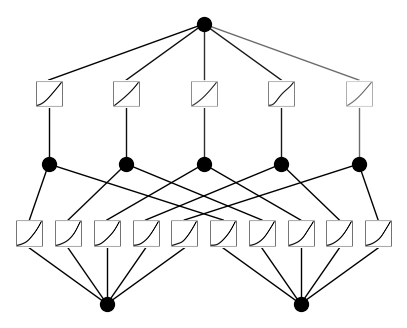

In [3]:
# plot KAN at initialization
model(dataset["train_input"])
model.plot(beta=100)

In [14]:
# train the model
model.train(dataset, opt="LBFGS", steps=50, lamb=0.01, lamb_entropy=10.0, device='cuda')

train loss: 7.31e-02 | test loss: 8.13e-02 | reg: 1.52e+01 : 100%|██| 50/50 [00:38<00:00,  1.30it/s]


{'train_loss': [array(0.07052885, dtype=float32),
  array(0.07419439, dtype=float32),
  array(0.07794511, dtype=float32),
  array(0.0726656, dtype=float32),
  array(0.07440107, dtype=float32),
  array(0.07432366, dtype=float32),
  array(0.07419076, dtype=float32),
  array(0.07093243, dtype=float32),
  array(0.07096983, dtype=float32),
  array(0.07096927, dtype=float32),
  array(0.06933523, dtype=float32),
  array(0.06856099, dtype=float32),
  array(0.06887721, dtype=float32),
  array(0.06893044, dtype=float32),
  array(0.06892055, dtype=float32),
  array(0.07140378, dtype=float32),
  array(0.07179497, dtype=float32),
  array(0.07085689, dtype=float32),
  array(0.07062845, dtype=float32),
  array(0.0707791, dtype=float32),
  array(0.07100589, dtype=float32),
  array(0.07097815, dtype=float32),
  array(0.07099793, dtype=float32),
  array(0.07099794, dtype=float32),
  array(0.07100901, dtype=float32),
  array(0.06903596, dtype=float32),
  array(0.06941684, dtype=float32),
  array(0.069803

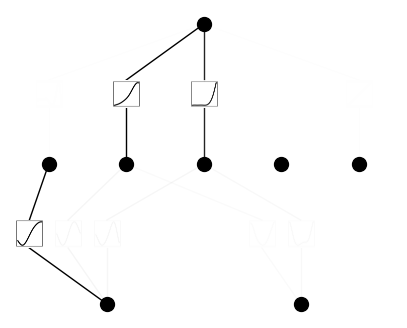

In [15]:
model.plot()

In [22]:
i, j = -0.1, 0.4
torch.exp(torch.sin(torch.pi * torch.tensor([i]) + torch.tensor([j]) ** 2)), model(
    torch.tensor([[i, j]], device="cuda")
)

(tensor([0.8577]), tensor([[0.8898]], device='cuda:0', grad_fn=<AddBackward0>))

In [1]:
m_list = []
l_list = []
for i in range(-500, 500):
    m = model(torch.tensor([[i / 100, j]], device="cuda")).cpu().detach().numpy()
    m_list.append(m[0][0])
    l = torch.exp(
        torch.sin(torch.pi * torch.tensor([i / 100]) + torch.tensor([j]) ** 2)
    )
    l_list.append(l)

import matplotlib.pyplot as plt

plt.plot(m_list)
plt.plot(l_list)

plt.legend(["prediction", "ground truth"])

NameError: name 'model' is not defined